In [2]:
from __future__ import division
import os,time,pdb
import numpy as np

#web 
import urllib

#reddit
import praw

#nlp
import nltk, re, pprint
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk import word_tokenize

from bs4 import BeautifulSoup
from bs4 import SoupStrainer
    
#scikit-learn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn import manifold
from sklearn.linear_model import SGDClassifier,LogisticRegression,Perceptron
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics
 


#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline
# Set some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['legend.fontsize'] = 20

# Helper functions


In [3]:
def order_soup(url=None):
    assert url is not None
    r = urllib.urlopen(url).read()
    return BeautifulSoup(r)

def get_subreddit_comments(url=None, tag='main'):
    soup = order_soup(url)
    comments = soup.find_all("div", class_= tag)
    text_list = []
    for node in comments:
        text_list.append(''.join(node.findAll(text=True)))
    return text_list

def tokenize_it(text_list):
    return word_tokenize(text_list)

def stem_list(word_list):
    mapstem = lambda x: stemmer.stem(x)    
    tokens = tokenize_it(word_list)
    stem_dep = map(mapstem,tokens)
    
def get_comments_from_url_list(url_list, tag, n=20, verbose=True):
    text = []
    for j in xrange(n):
        for i in xrange(len(url_list)):
            if verbose:
                print url_list[i], j
            comments = get_subreddit_comments(url=url_list[i],tag=tag)
            text.extend(comments)
        if len(text)!=0:
            break
    return text

def get_text_from_subreddit(subreddit,limit=None):
    sr = r.get_subreddit('schizophrenia')
    comments = sr.get_comments(limit=limit)
    text = []
    for c in comments:
        text.append(c.body)    

#Scrape comments from reddit 

In [4]:
r = praw.Reddit('Test by u/_Daimon_')

In [5]:
subreddits = ['schizophrenia', 'depression', 'bipolar']

In [6]:
text = []
labels = []
for i, sr in enumerate(subreddits):
    comments = r.get_subreddit(sr).get_comments(limit=None)
    count=0
    for c in comments:
        text.append(c.body) 
        labels.append(i+1)
        count+=1
    print '\n%i comments from subreddit: %s fetched!'%(count,sr)
y = np.array(labels)


998 comments from subreddit: schizophrenia fetched!

896 comments from subreddit: depression fetched!

1000 comments from subreddit: bipolar fetched!


# Count vectors

In [7]:
count_vect = CountVectorizer()
count_vect.fit(text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
counts = count_vect.transform(text)

In [63]:
counts[0,:1000].shape

(1, 1000)

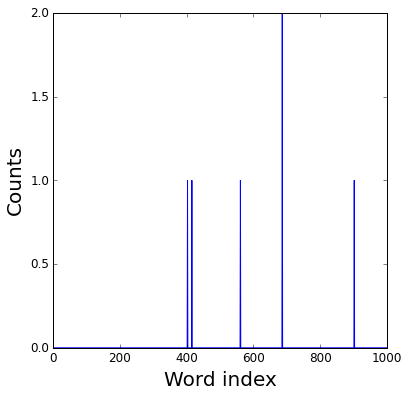

In [67]:
plt.plot(counts[0,:1000].toarray()[0,:1000])
plt.ylabel('Counts')
plt.xlabel('Word index')

# Frequency vectors

In [9]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(counts)

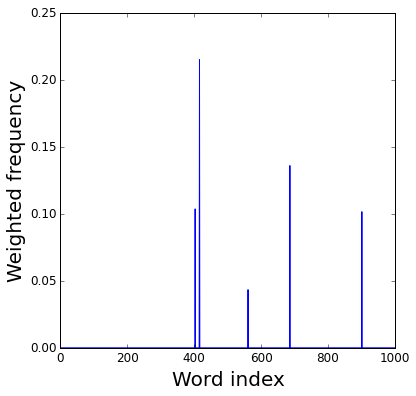

In [68]:
plt.plot(X.toarray()[0,:1000])
plt.ylabel('Weighted frequency')
plt.xlabel('Word index')

# Visualizations

## PCA

In [124]:
pca = PCA(n_components=.90)
X_pca = pca.fit_transform(X.toarray())

In [127]:
X_pca.shape

(2894, 1523)

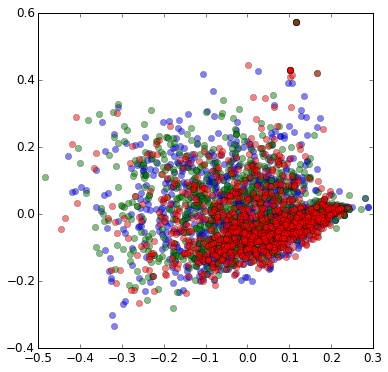

In [125]:
for i in np.arange(1,4):
    plt.plot(X_pca[np.where(y==i)[0],0],X_pca[np.where(y==i)[0],1],'o',alpha=.5)

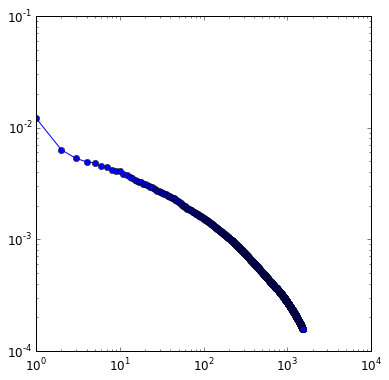

In [126]:
plt.loglog(pca.explained_variance_ratio_,'o-')

## Feature analysis

In [51]:
idx1 = np.argsort(abs(pca.components_[0]))[:20]
idx2 = np.argsort(abs(pca.components_[1]))[:20]

In [52]:
np.array(count_vect.vocabulary_.keys())[idx2]

array([u'evolve', u'identical', u'intention', u'tasks', u'most',
       u'considered', u'dependent', u'lodged', u'vice', u'attribution',
       u'compellingly', u'livvy', u'therapeutic', u'watch', u'tv',
       u'succeeds', u'hahaha', u'atone', u'applications', u'sight'], 
      dtype='<U89')

In [53]:
np.array(count_vect.vocabulary_.keys())[idx1]

array([u'sudden', u'nieroscience', u'youtu', u'cultures', u'amphetamine',
       u'withdrawing', u'continued', u'scheming', u'age', u'peers',
       u'floaties', u'preferable', u'betray', u'companies', u'alternate',
       u'tend', u'mi', u'leg', u'late', u'neighbors'], 
      dtype='<U89')

## t-SNE

In [ ]:
tsne = manifold.TSNE(n_components=2)
Y2 = tsne.fit_transform(X_pca[:,:3])

# Decoding 

## train-test split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.20, random_state=42)

In [129]:
X_test.shape

(579, 1523)

## Linear SVM

In [139]:
clf = LinearSVC(C=1e-1)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)   

In [140]:
predicted_train = clf.predict(X_train)   

###Classification report

Precision-recall

In [141]:
print(metrics.classification_report(y_test, predicted,target_names=subreddits))

               precision    recall  f1-score   support

schizophrenia       0.60      0.49      0.54       209
   depression       0.65      0.55      0.60       183
      bipolar       0.53      0.71      0.60       187

  avg / total       0.59      0.58      0.58       579



In [142]:
print(metrics.classification_report(y_train, predicted_train,target_names=subreddits))

               precision    recall  f1-score   support

schizophrenia       0.87      0.84      0.85       789
   depression       0.83      0.83      0.83       713
      bipolar       0.83      0.86      0.85       813

  avg / total       0.84      0.84      0.84      2315



confusion matrix

In [134]:
cm = metrics.confusion_matrix(y_test, predicted)

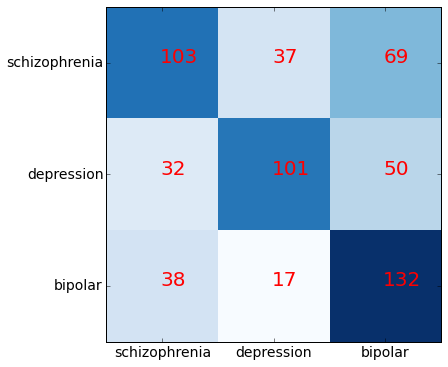

In [135]:
ax = plt.axes()
im = ax.imshow(cm,aspect='auto',interpolation='nearest',\
                   cmap=plt.cm.Blues)
for i in xrange(cm.shape[0]):
    for j in xrange(cm.shape[1]):
        textLabel = '%i'%cm[j,i]
        ax.text(i,j,textLabel,color='red',fontsize=20)
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(subreddits,fontsize=14)
ax.set_yticklabels(subreddits,fontsize=14)

SVM weights

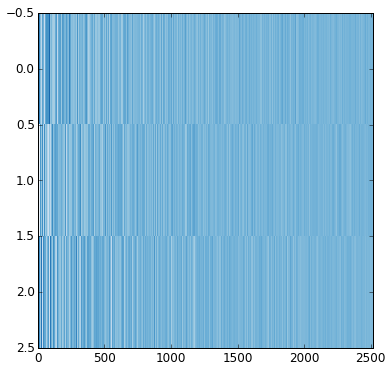

In [20]:
plt.imshow(clf.coef_,aspect='auto',interpolation='nearest',\
                   cmap=plt.cm.Blues)
plt.show()

In [80]:
n_weights = 2
best_weights = np.zeros((len(subreddits),n_weights),dtype='int')
for i in xrange(len(subreddits)):
    best_weights[i]=np.argsort(abs(clf.coef_[i]))[:n_weights]

In [81]:
n_components = 2
best_components = np.zeros((len(subreddits),n_components, 10254))
for i in xrange(len(subreddits)):
    best_components[i]= pca.components_[best_weights[i]]

In [98]:
n_words = 3
idx = np.argsort(best_components,axis=2)[...,:n_words].reshape((3,n_words*n_components))

In [100]:
final_words = np.zeros(idx.shape,dtype='S8')
for i in xrange(len(subreddits)):
    final_words[i] = np.array(count_vect.vocabulary_.keys())[idx[i]]

In [104]:
np.repeat(best_weights,3,axis=1).shape, final_words.shape

((3, 6), (3, 6))

In [123]:
zip(final_words,subreddits)

[(array(['periodic', 'aligned', 'desert', 'prodding', 'techniqu', 'hahah'], 
        dtype='|S8'), 'schizophrenia'),
 (array(['quit', 'formed', 'dulled', 'braces', 'believed', 'itch'], 
        dtype='|S8'), 'depression'),
 (array(['ceiling', 'falsely', 'firmly', 'quit', 'dea', 'ton'], 
        dtype='|S8'), 'bipolar')]

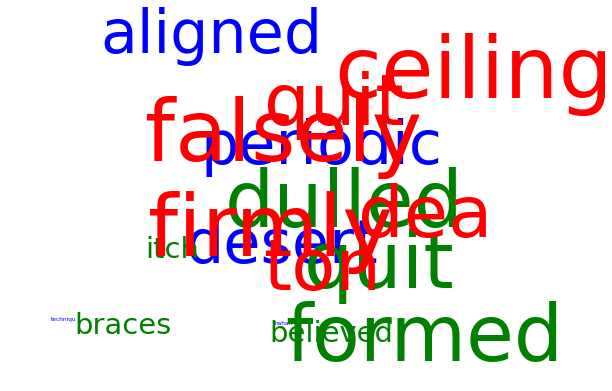

In [122]:
color = ['b','g','r']
fig = plt.figure()
ax = fig.add_subplot(111)
for i in xrange(final_words.shape[0]):
    for j in xrange(final_words.shape[1]):
        ax.text(np.random.uniform(0,1),np.random.uniform(0,1),final_words[i,j],
                fontsize=np.repeat(best_weights,3,axis=1)[i,j]/20.,color=color[i])
ax.set_axis_off()

## Logistic regression

In [ ]:
logis = LogisticRegression(C=1.)
logis.fit(X_train, y_train)
pred_logis = clf.predict(X_test)